Extract measures and create df

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from Wind.Results import DBResults, DBMeasures
from Wind.Util.Maps import create_mapbox_plot
from Wind.Private.DBConfig import mapbox_token
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
from Wind.Private.DBConfig import mongolocaltest, mongolocal, mongolocalmeasures
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from statsmodels.genmod.generalized_linear_model import GLM
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr, kendalltau,spearmanr

In [34]:
def create_lat_lon(sites):
   list_sites = sites['site'].tolist()
   latlon_df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/20190823Summary_file.csv')
   df = latlon_df.loc[latlon_df['site_number'].isin(list_sites)]
   return df

In [35]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a=results.extract_result(dset='test')

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()
a = a[a[:,0].argsort()] # we sort by first column

In [36]:
mongolocalmeasures

In [37]:
df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

In [38]:
df_states.columns

Index(['site_number', 'site', 'seas_index', 'Lon-old', 'Lat-old',
       'Persistence-test', 'Persistence-val', 'MLP_s2s_2-test',
       'MLP_s2s_2-val', 'Lat_trunc', 'Lon_trunc', 'state', 'Lat', 'Lon',
       'JM_CNN_sep_2l_FULL-test', 'JM_CNN_sep_2l_FULL-val', 'MLP_s2s_elu-test',
       'MLP_s2s_elu-val', 'CNN_s2s_elu-test', 'CNN_s2s_elu-val',
       'JM_RF_s2s_2-test', 'JM_RF_s2s_2-val', 'elevation', 'complexity',
       'seasonal', 'residual', 'trend', 'complexity_riley',
       'strength_seasonality', 'strength_trend', 'mean', 'var', 'kurtosis',
       'skew'],
      dtype='object')

In [39]:
df_states['JM_CNN_sep_2l_FULL-test']

0         9.722198
1         8.382961
2         7.936336
3         7.937454
4         7.959334
            ...   
126687    8.612049
126688    7.427967
126689    9.196405
126690    8.476522
126691    9.261023
Name: JM_CNN_sep_2l_FULL-test, Length: 126692, dtype: float64

In [40]:
measure.measures

['SpecEnt',
 'SampEnt',
 'Stab12h',
 'Lump12h',
 'Stab24h',
 'Lump24h',
 'Stab1w',
 'Lump1w',
 'Stab1m',
 'Lump1m',
 'Stab3m',
 'Lump3m',
 'Stab6m',
 'Lump6m',
 'Trend12h',
 'Season12h',
 'Trend24h',
 'Season24h',
 'Trend1m',
 'Season1m']

In [41]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
b5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
b7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'state': df_states['state']})

In [32]:
# Table 3
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation FT 12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend24h_wind_speed'])
print('correlation FT 24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend1m_wind_speed'])
print('correlation FT 1m',correlation)
print('--------------')
correlation = data['CNN_sep_2L'].corr(data['Season12h_wind_speed'])
print('correlation ST 12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season24h_wind_speed'])
print('correlation ST 24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season1m_wind_speed'])
print('correlation ST 1m',correlation)

correlation FT 12h 0.8339406237157402
correlation FT 24hh 0.8877958718582855
correlation FT 1m 0.4731308595102287
correlation ST 12h -0.19903601717908878
correlation ST 24hh 0.15317702490726845
correlation ST 1m -0.04208742984171607


In [35]:
df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

zs = df[["strength_seasonality"]].to_numpy()
ys = df[["strength_trend"]].to_numpy()

df_tmp = pd.DataFrame({'x':a[:,1], 'trend': ys[:,0], 'season': zs[:,0]})

correlation_trend = pearsonr(a[:,1],ys[:,0])
correlation_season = pearsonr(a[:,1],zs[:,0])
print('correlation seasonal least squares 24h',correlation_season)
print('correlation trend least squares 24h',correlation_trend)

correlation seasonal least squares 24h (0.10995214396437283, 0.0)
correlation trend least squares 24h (0.8414067852374699, 0.0)


In [11]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':b1[:,1], 'Trend12h_wind_speed':b2[:,1], 'Trend1m_wind_speed':b3[:,1]})
correlation = data['CNN_sep_2L'].corr(data['Trend24h_wind_speed'])
print('correlation Trend24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation Trend12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend1m_wind_speed'])
print('correlation Trend1m',correlation)

correlation Trend24h 0.8877958718582855
correlation Trend12h 0.8339406237157402
correlation Trend1m 0.4731308595102287


In [12]:
measure.measures

['SpecEnt',
 'SampEnt',
 'Stab12h',
 'Lump12h',
 'Stab24h',
 'Lump24h',
 'Stab1w',
 'Lump1w',
 'Stab1m',
 'Lump1m',
 'Stab3m',
 'Lump3m',
 'Stab6m',
 'Lump6m',
 'Trend12h',
 'Season12h',
 'Trend24h',
 'Season24h',
 'Trend1m',
 'Season1m']

In [13]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Season24h_wind_speed':b1[:,1], 'Season12h_wind_speed':b2[:,1], 'Season1m_wind_speed':b3[:,1]})
correlation = data['CNN_sep_2L'].corr(data['Season24h_wind_speed'])
print('correlation season24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season12h_wind_speed'])
print('correlation Season12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season1m_wind_speed'])
print('correlation Season1m',correlation)

correlation season24h 0.15317702490726845
correlation Season12h -0.19903601717908878
correlation Season1m -0.04208742984171607


correlation (0.8877958718582878, 0.0)


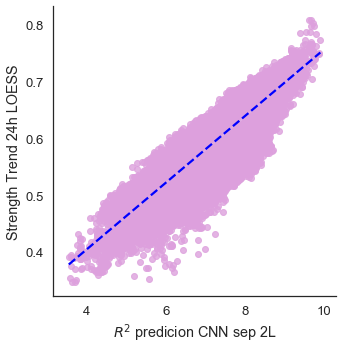

In [36]:
# Strength Trend LOESS
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
df_tmp = pd.DataFrame({'x':a[:,1], 'y': b[:,1]})

correlation = pearsonr(a[:,1], b[:,1])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend 24h LOESS')
#snsplot.set(ylim=(0, None))

snsplot.savefig('e:/figures/Strength_trend_LOESS.png')
snsplot.savefig('e:/figures/Strength_trend_LOESS.pdf')

In [15]:
df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

zs = df[["strength_seasonality"]].to_numpy()
ys = df[["strength_trend"]].to_numpy()

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend_strength_wind_speed':ys[:,0], 'strenght_seasonality_wind_speed':zs[:,0]})
correlation = data['CNN_sep_2L'].corr(data['Trend_strength_wind_speed'])
print('correlation Trend_strength_wind_speed',correlation)

correlation = data['CNN_sep_2L'].corr(data['strenght_seasonality_wind_speed'])
print('strenght_seasonality_wind_speed',correlation)


correlation Trend_strength_wind_speed 0.8414067852374743
strenght_seasonality_wind_speed 0.1099521439643725


correlation (0.8414067852374699, 0.0)


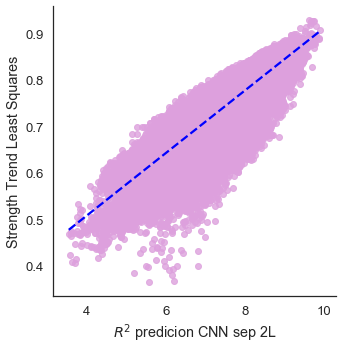

In [16]:
# Grafico de Strenght trend  least squares (como thesis)
import matplotlib.pylab as plt
df_tmp = pd.DataFrame({'x':a[:,1], 'y': ys[:,0]})

correlation = pearsonr(a[:,1],ys[:,0])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})

snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend Least Squares')
snsplot.savefig('e:/figures/Strength_trend_Least_squares.png')

correlation (0.10995214396437283, 0.0)


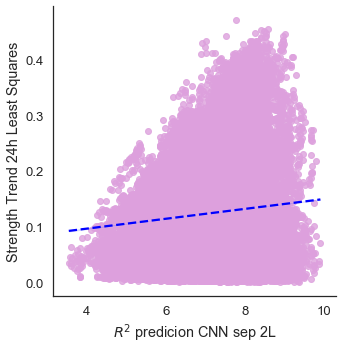

In [17]:
# grafico de Seasonality strhngth 24h least squares

df_tmp = pd.DataFrame({'x':a[:,1], 'y': zs[:,0]})

correlation = pearsonr(a[:,1],zs[:,0])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend 24h Least Squares')
snsplot.savefig('e:/figures/Strength_Seasonal_Least_squares.png')

correlation (0.15317702490727572, 0.0)


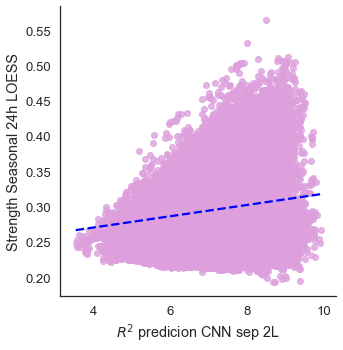

In [18]:
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
df_tmp = pd.DataFrame({'x':a[:,1], 'y': b[:,1]})

correlation = pearsonr(a[:,1],b[:,1])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Seasonal 24h LOESS')
#snsplot.set(ylim=(0, None))

snsplot.savefig('e:/figures/Strength_Seasonal_LOESS.png')

In [19]:
# Creamos dataframe con las dos medidas St_LOESS y St_LSQ
df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')
b1 = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
zs = df_states[["strength_trend"]].to_numpy()

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'St_LOESS':b1[:,1], 'St_LSQ':zs[:,0], 'state': df_states['state']})

In [20]:
data.columns

Index(['test', 'CNN_sep_2L', 'St_LOESS', 'St_LSQ', 'state'], dtype='object')

In [21]:
# correlations between LOESS and ...
df = data

states = ["AL", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", 
          "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "ER"]
# DC, Alaska and Hawaii have no sites (AK, HI, DC)
print('SpecEnt_wind_speed')
for st in states:

    pdX = df[((df['state']==st))  ]
    correlation1 = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
    correlation2 = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
    n = pdX.shape[0]
    print(st,'-', round(correlation1, 3), round(correlation2, 3), 'state_sites', n+1)

SpecEnt_wind_speed
AL - 0.803 0.838 state_sites 89
AZ - 0.783 0.845 state_sites 2376
AR - 0.768 0.808 state_sites 823
CA - 0.837 0.897 state_sites 4053
CO - 0.81 0.851 state_sites 3652
CT - 0.882 0.886 state_sites 156
DE - 0.915 0.899 state_sites 151
FL - 0.726 0.73 state_sites 1040
GA - 0.54 0.485 state_sites 273
ID - 0.835 0.879 state_sites 1451
IL - 0.393 0.555 state_sites 5253
IN - 0.881 0.914 state_sites 3195
IA - 0.639 0.733 state_sites 5253
KS - 0.923 0.935 state_sites 4150
KY - 0.801 0.83 state_sites 347
LA - 0.879 0.879 state_sites 558
ME - 0.907 0.92 state_sites 1201
MD - 0.952 0.963 state_sites 334
MA - 0.914 0.914 state_sites 676
MI - 0.606 0.71 state_sites 3609
MN - 0.81 0.841 state_sites 6372
MS - 0.797 0.876 state_sites 187
MO - 0.816 0.883 state_sites 1836
MT - 0.905 0.924 state_sites 4091
NE - 0.89 0.911 state_sites 3708
NV - 0.795 0.855 state_sites 3865
NH - 0.854 0.876 state_sites 409
NJ - 0.912 0.907 state_sites 483
NM - 0.852 0.885 state_sites 6584
NY - 0.879 0.898

Text(0.5, 0.98, 'Wyoming')

correlation FT LOESS 0.9456901065621138
correlation FT Least Squares 0.9368053949463422


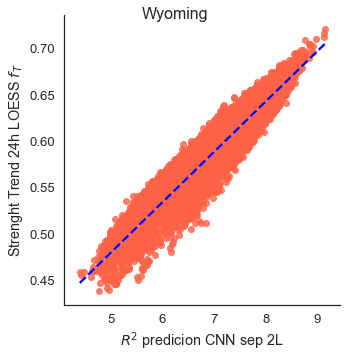

In [22]:
# Mapa de Wyoming
df = data
pdX = df[(df['state']=='WY')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "tomato"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Wyoming", fontsize=16)

snsplot.savefig('e:/figures/F2_Wyoming.png')

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

Text(0.5, 0.98, 'Illinois')

correlation FT LOESS 0.5548201425505271
correlation FT Least Squares 0.392852740693512


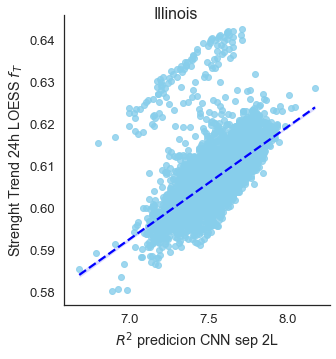

In [23]:
# Mapa de Illinois
df = data
pdX = df[(df['state']=='IL')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Illinois", fontsize=16)

snsplot.savefig('e:/figures/F2_Illinois.png')

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

Text(0.5, 0.98, 'Montana')

correlation FT LOESS 0.923968222866522
correlation FT Least Squares 0.9049892001814254


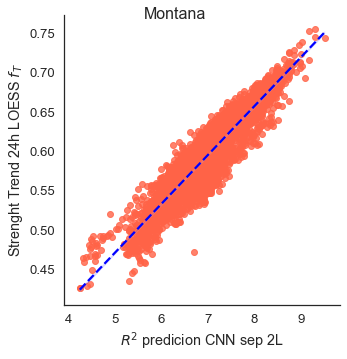

In [24]:
# Mapa de Montana
df = data
pdX = df[(df['state']=='MT')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "tomato"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Montana", fontsize=16)

snsplot.savefig('e:/figures/F2_Montana.png')

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

Text(0.5, 0.98, 'Wisconsin')

correlation FT LOESS 0.6267344560720921
correlation FT Least Squares 0.5001890013181028


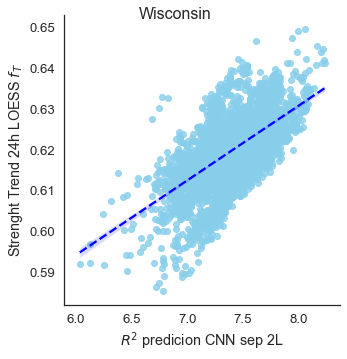

In [25]:
# Mapa de Illiinois
df = data
pdX = df[(df['state']=='WI')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Wisconsin", fontsize=16)

snsplot.savefig('e:/figures/F2_Wisconsin.png')

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

### New Measures

In [60]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a=results.extract_result(dset='test')

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()
a = a[a[:,0].argsort()] # we sort by first column

# Use Sampent and TrendLoess
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')

Text(0.5, 1.0, 'Strength Trend 24h vs SpectEnt')

Text(0.5, 0, 'Strength Trend 24h')

Text(0, 0.5, 'SpecEnt')

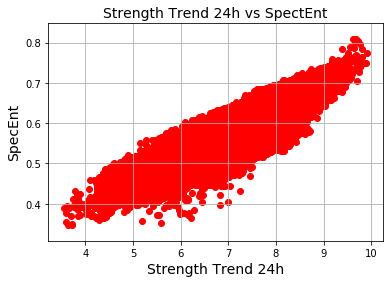

In [61]:
# obtaining correlations linear regression

df_multi = pd.DataFrame({'x':a[:,1], 'y': b[:,1], 'z' : c[:,1]})

#df_multi['y'] = df_multi['y'] * -1 # we modify the slope

plt.scatter(df_multi['x'], df_multi['y'], color='red')
plt.title('Strength Trend 24h vs SpectEnt', fontsize=14)
plt.xlabel('Strength Trend 24h', fontsize=14)
plt.ylabel('SpecEnt', fontsize=14)
plt.grid(True)
plt.show()

In [62]:
# por alguna razon oscura SpecEnt tiene 15 o 20 nulls
# hacemos una ñapa y eliminamos las filas
a = df_multi['z'].notnull()
df_multi1 = df_multi[a]

In [63]:
from sklearn import linear_model
import statsmodels.api as skl

X = df_multi1[['y', 'z']]
Y = df_multi1['x']

In [64]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Intercept: 
 9.357093468118451
Coefficients: 
 [ 9.1568999 -0.6952496]


In [67]:
# new measure

NM  = regr.intercept_ + regr.coef_[0] * df_multi1['y'] + regr.coef_[1] * df_multi1['z']

In [68]:
correlation = df_multi1['x'].corr(NM)
correlation1 = df_multi1['x'].corr(df_multi1['y'])
correlation2 = df_multi1['x'].corr(df_multi1['z'])
print('correlation x - NM :',correlation)
print('correlation x - y  :', correlation1)
print('correlation x - z  :', correlation2)

correlation x - NM : 0.9181285178118812
correlation x - y  : 0.8877898705192981
correlation x - z  : -0.8308333559942153
